In [1]:
#main para programadores 
#ajuste de trânsitos 
# Este ajuste pode ser feito com a rotina Amoeba (minimização multidimensional de uma função) ou através do MCMC.

#imports
from model import Modelo,Tratamento,Ajuste
from verify import converte
from estrela_nv1 import estrela
from eclipse_nv1 import Eclipse
import numpy
import matplotlib.pyplot as plt
import emcee
from scipy import interpolate
import corner

from lmfit import Model

# cria Estrela e Eclipse

In [2]:
raio = 373. #default (pixel)
intensidadeMaxima = 240 #default
tamanhoMatriz = 856 #default 
u1 = 0.44
u2 = 0.10

'''
rsun = 0.117 # raio da estrela em Rsun
raioPlanJup = 0.0819 # raio do planeta (em RJup)
semiEixoUA = 0.028 #semieixo (UA)
anguloInclinacao = 89.86 #em graus
periodo = 6.099  # day
'''

lua = False 
ecc = 0
anom = 0


raioPlanJup = 1.41
semiEixoUA = 0.028
rsun = 1.05 # raio da estrela em Rsun
anguloInclinacao = 89. #em graus
periodo = 1.4857108  # day


#etapa de conversão
raioStar, raioPlanetaRstar , semiEixoRaioStar = converte(rsun,raioPlanJup,semiEixoUA)

star_name = 'Kepler-17'
cadence = 'short'


0.09000039100646973


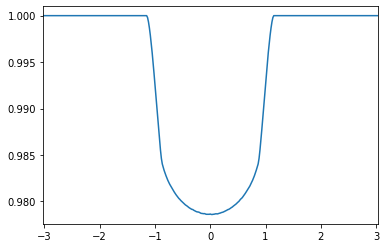

In [3]:
#raio, raioStar, intensidadeMaxima,coeficienteHum,coeficienteDois,tamanhoMatriz
estrela_ = estrela(raio,raioStar,intensidadeMaxima,u1,u2,tamanhoMatriz)
Nx = estrela_.getNx()
Ny = estrela_.getNy()
raioEstrelaPixel = estrela_.getRaioStar()
estrelaManchada = estrela_.getEstrela()
eclipse = Eclipse(Nx,Ny,raioEstrelaPixel,estrelaManchada)

estrela_.setStarName(star_name)
estrela_.setCadence(cadence)


######################################################################################
eclipse.setTempoHoras(1.)
######################################################################################


#semiEixoRaioStar,semiEixoUA, raioPlanetaRstar, raioPlanJup ,periodo,anguloInclinacao,lua,ecc,anom
eclipse.criarEclipse(semiEixoRaioStar,semiEixoUA,raioPlanetaRstar,raioPlanJup,periodo,anguloInclinacao,lua,ecc,anom,False)
lc0 = numpy.array(eclipse.getCurvaLuz()) 
ts0 = numpy.array(eclipse.getTempoHoras())

0.08300113677978516


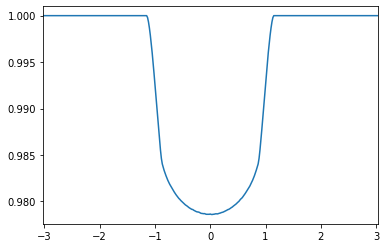

D:\IC2\pipelineMCMC\model.py:102: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  lc = search_lightcurvefile(self.star_name, cadence = self.cadence).download_all().PDCSAP_FLUX
D:\IC2\pipelineMCMC\model.py:102: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = search_lightcurvefile(self.star_name, cadence = self.cadence).download_all().PDCSAP_FLUX
d:\users\pinho\appdata\local\programs\python\python38-64\lib\site-packages\lightkurve\collections.py:164: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  return LightCurveCollection([lc.PDCSAP_FLUX for lc in self])
d:\users\pinho\appdata\local\programs\python\python38-64\lib\site-packages\lightkurve\collections.py:164: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed

In [4]:
modelo = Modelo(estrela_,eclipse)

ls_model, ts_model = modelo.eclipse_model()

time, flux, flux_err = modelo.rd_data(0, 0)

time2 = time

modelo.setTime(time2)
modelo.setFlux(flux)
modelo.setFluxErr(flux_err)

x0, nt = modelo.det_x0(0)

#a1 = 5.179
#inc1 = 87.69
#per1 = 1.381
#rp1 = 0.13

0.08299708366394043


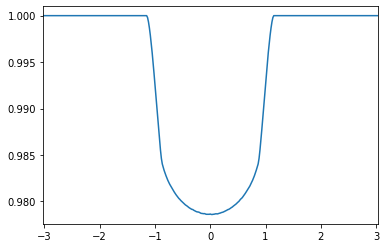

In [5]:
tratamento = Tratamento(modelo)

dur, tim, lcurve, f_err = tratamento.cut_transit_single()

t_p = tim[0]
s_lc = lcurve[0]

bb = numpy.where((t_p >= min(ts0)) & (t_p <= max(ts0)))
bb = numpy.where((ts0 >= -5.) & (ts0 <= 5.))
dd = numpy.where((t_p >= -5.) & (t_p <= 5.))

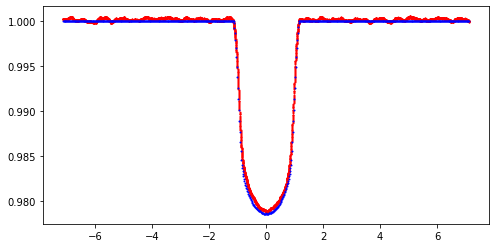

In [6]:
time_phased, smoothed_LC = tratamento.transit_smooth(10, 1)

plt.rcParams['figure.figsize']= 8, 4
graf1,ax = plt.subplots()

ax.plot(time_phased, smoothed_LC, "r.", ms = 2)
ax.plot(ts_model, ls_model, "b.", ms = 2)

# MCMC

In [7]:
nwalkers = 50
niter = 50
burnin = 30

ajuste = Ajuste(tratamento, time_phased, smoothed_LC, nwalkers, niter, burnin)

time = time_phased
flux = smoothed_LC

In [8]:
sampler, pos, prob, state = ajuste.main()

Running burn-in...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [17:33<00:00, 35.11s/it]


Running production...


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [27:35<00:00, 33.11s/it]


In [9]:
samples = sampler.flatchain
samples[numpy.argmax(sampler.flatlnprobability)]

array([4.15427442e-01, 4.66889489e-01, 1.68747263e-02, 8.75157986e+01,
       1.25789696e+00])

[4.15427442e-01 4.66889489e-01 1.68747263e-02 8.75157986e+01
 1.25789696e+00]


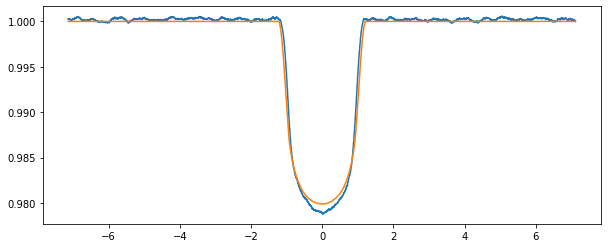

Theta max:  [4.15427442e-01 4.66889489e-01 1.68747263e-02 8.75157986e+01
 1.25789696e+00]


In [10]:
theta_max  = samples[numpy.argmax(sampler.flatlnprobability)]
print(theta_max)
best_fit_model = ajuste.eclipse_mcmc(time, theta_max)

plt.rcParams['figure.figsize']= 10, 4
graf1,ax = plt.subplots()
plt.plot(time, flux, label = 'flux')
plt.plot(time, best_fit_model, label='Highest Likelihood Model')
plt.show()
print('Theta max: ',theta_max)

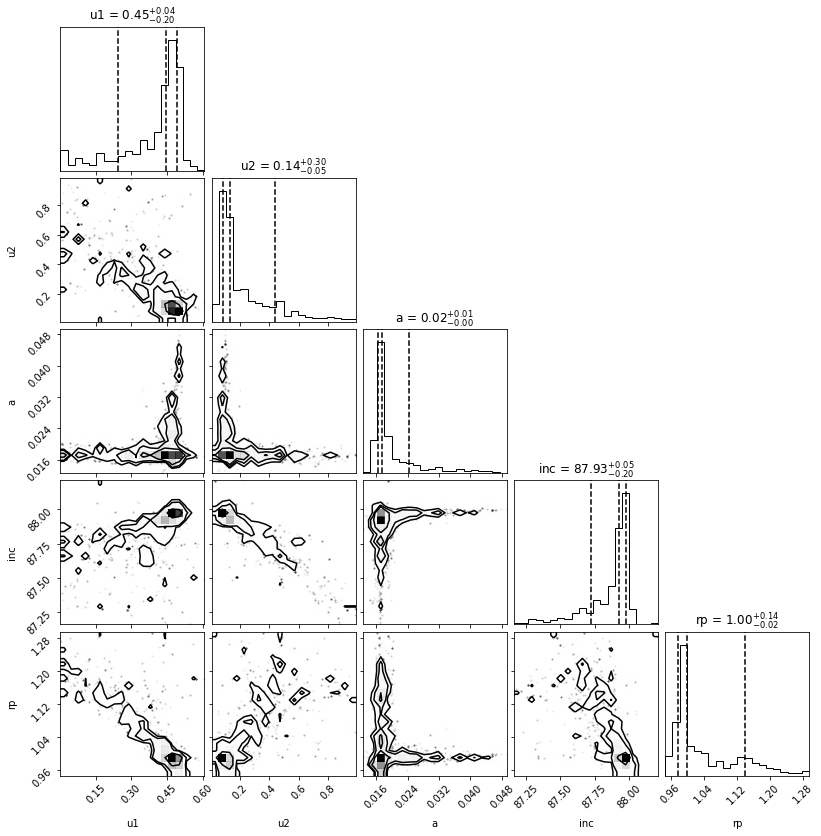

In [11]:
labels = ['u1','u2','a','inc','rp']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

In [ ]:
med_model, spread = sample_walkers(100,samples)

In [ ]:
plt.rcParams['figure.figsize']= 10, 4
graf1,ax = plt.subplots()

plt.plot(time, flux, label='flux')
plt.plot(time, best_fit_model, label='Highest Likelihood Model')
plt.fill_between(time, med_model-spread, med_model+spread,color='grey',alpha=0.5,label=r'$1\sigma$ Posterior Spread')
plt.legend()

In [ ]:
for i in range(ndim):
    mcmc = numpy.percentile(samples[:, i], [16, 50, 84])
    q = numpy.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

In [ ]:
plt.rcParams['figure.figsize']= 8, 4
graf1,ax = plt.subplots()

ax.plot(t_p[dd], s_lc[dd], "k.", ms = 2)
#ax.plot(t_p, s_lc, "k.", ms = 2)
ax.plot(ts0[bb], lc0[bb], "r.", ms = 2)

In [ ]:
plt.rcParams['figure.figsize']= 8, 4
graf1,ax = plt.subplots()

ax.plot(ts0[bb], s_lc[dd] - lc0[bb], "k.", ms = 2)

# Add manchas

In [ ]:
dtor = numpy.pi/180.


fa = [0.1, 0.05, 0.2, 0.1]
fi = [0.7, 0.5, 0.9, 0.7]
lg = [-30., 0., 30., 45.]

lat = - numpy.arcsin(a1*numpy.cos(inc1*dtor))/dtor

estrela = estrela_.manchas(fa[0], fi[0], lat, lg[0])
estrela = estrela_.manchas(fa[1], fi[1], lat, lg[1])
estrela = estrela_.manchas(fa[2], fi[2], lat, lg[2])
estrela = estrela_.manchas(fa[3], fi[3], lat, lg[3])

Nx = estrela_.getNx()
Ny = estrela_.getNy()
raioEstrelaPixel = estrela_.getRaioStar()
estrelaManchada = estrela_.getEstrela()

#criando eclipse manchado
eclipse = Eclipse(Nx,Ny,raioEstrelaPixel,estrelaManchada)
#semiEixoRaioStar,semiEixoUA, raioPlanetaRstar, raioPlanJup ,periodo,anguloInclinacao,lua,ecc,anom
eclipse.criarEclipse(semiEixoRaioStar,semiEixoUA,semiEixoUA,raioPlanJup,periodo,anguloInclinaca,lua,ecc,anom)
lc_model = numpy.array(eclipse.getCurvaLuz())
ts_model = numpy.array(eclipse.getTempoHoras())


In [ ]:
plt.rcParams['figure.figsize']= 8, 4
graf1,ax = plt.subplots()

ax.plot(tim[1], lcurve[1], "k.", ms = 2)
ax.plot(ts_model, ls_model, "r.", ms = 2)

In [ ]:
plt.rcParams['figure.figsize']= 8, 4
graf1,ax = plt.subplots()

#ax.plot(ts_model, ls_model, "k.", ms = 2)
ax.plot(tim[1], lcurve[1] - ls_model, "k.", ms = 2)